# Tutorial 3 – An untrained generative model with qubits

Welcome back to our tutorial on generative modeling with quantum hardware. So far, we have learned that, in a generative machine learning task, you receive data and the goal is to learn a model of the true distribution underlying the data. Then, you want to be able to generate new data from this model, which has similar characteristics, but is not necessarily inside the training set.\
The moving pieces are:
- **The dataset**. What type of data is it?
- **The model**. Is it flexible enough to approximate the data distribution well? Or is it highly specialized like in the earlier gaussian case?
- **The loss function**. How do you estimate the distance between the training data samples and your model distribution?
- **The optimization algorithm**. How do you get from (potentially very bad) initial parameters to a good set of parameters?

In this tutorial, we will be focusing on the **model** component, and replace the gaussian probability density function of the last two tutorials with a **quantum circuit**. In turn, we will also have a look at how to adapt the **dataset** such that it is compatible with the quantum circuit model.

To simulate the outcomes of quantum circuits, we will be using the *qiskit* Python library. See more about **qiskit** [here](https://qiskit.org/).

Lets first install **qiskit** and import the necessary Python libraries.

In [1]:
# !pip install qiskit
# !pip install pylatexenc

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer

## A brief reminder of quantum circuits 

In our [Quantum Machine Learning Tutorial 101](qml101), we presented this minimal example of a quantum circuit with one qubit and one parameter $\theta$.  

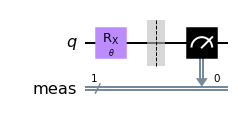

In [3]:
# define a symbolic parameter theta
theta = Parameter(r"$\theta$")

# create a quantum circuit with one qubit
circuit = QuantumCircuit(1)
# apply an X rotation with the symbolic parameter theta
circuit.rx(theta, 0)
# define the measurement
circuit.measure_all()
# draw the resulting circuit
circuit.draw("mpl")

This diagram represents the what we just coded up using **qiskit**: We start with one qubit, apply one gate, and then measure it. Let us now find out how the value of $\theta$ modulates the distribution of outcomes.

To run the circuit, we need to import and initialize a simulator backend:

In [4]:
simulator = Aer.get_backend("aer_simulator")

The results for theta = 0.785 was: {'0': 844, '1': 156}
The results for theta = 1.571 was: {'0': 530, '1': 470}
The results for theta = 2.356 was: {'0': 143, '1': 857}


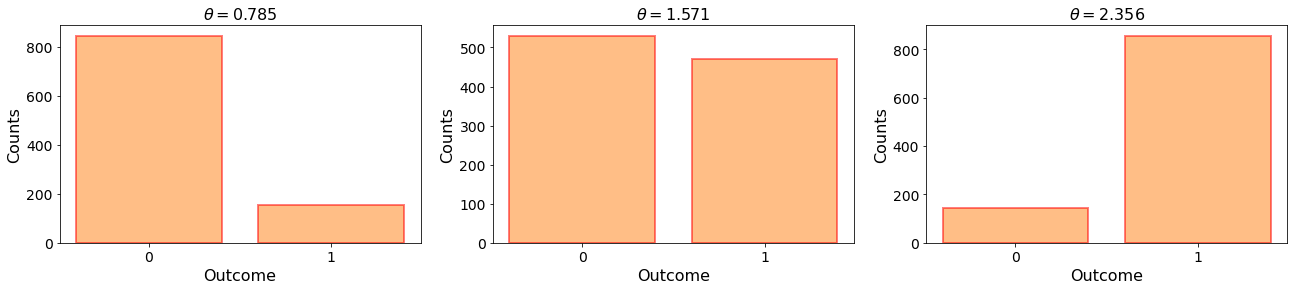

In [5]:
# to plot it up
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,4))

for ax, theta in zip((ax1, ax2, ax3), [np.pi*1/4, np.pi*1/2, np.pi*3/4]):

    # bind the parameter theta of the circuit to pi/4
    circuit_with_params = circuit.bind_parameters([theta])

    # run the circuit and get the result
    result = simulator.run(circuit_with_params, shots=1000).result()

    # extract the measurement counts as a python dictionary
    count_dict = result.get_counts()

    # for convenience sort by binary order 
    count_dict = dict(sorted(count_dict.items()))

    # print the counts
    print(f"The results for theta = {round(theta, 3)} was:", count_dict)

    ax.bar(
      count_dict.keys(),
      count_dict.values(),
      alpha=0.5,
      color="tab:orange",
      edgecolor="red",
      linewidth=2,
    )
    ax.set_title(rf"$\theta =${round(theta, 3)}", fontsize=16)
    ax.set_ylabel("Counts", fontsize=16)
    ax.set_xlabel("Outcome", fontsize=16)
    ax.tick_params(labelsize=14)
plt.show()

It becomes clear that $\theta$ controls the probability distribution over outcomes "0" or "1". $\theta=\frac{\pi}{2}$ creates an equal superposition of "0" and "1" in the measurement basis, wheras $\theta=\frac{\pi}{4}$ and $\theta=\frac{3\pi}{2}$ had a larger probability for measuring "0" or "1", respectively. The slight discrepancy in the measurement outcomes from the exact probabilities, for example $50\%$ "0" and $50\%$ "1" for the $\theta=\frac{\pi}{2}$ case, are due to the inherent randomness of quantum measurements. If you toss a coin 1000 times, the most likely individual outcome is 500/500, but you are very unlikely to get that perfect balance of outcomes and not any other outcome that is close to it. However, if you take more and more measurements, the observed probabilities of measurements will approach the exact probabilities of $50\%$.

## Designing and measuring a parametrized quantum circuit

Let us now write a function that returns a **qiskit** circuit with a flexible number of qubits $n$, and with varying *depth* $d$. The *depth* of a quantum circuit is a vague term for the number of gates in a quantum circuit, or, more commonly, how often a fixed structure of gates is repeated. These structures are commonly called circuit *layers*. Because we will be working with multiple qubits, the quantum circuit should also contain two-qubit *CNOT* gates. In addition to the $\theta$ values of single-qubit gates controlling the measurement probabilities for each qubit, the *CNOT* gates correlate the measurement outcomes and create *entanglement* in the prepared quantum state. See our tutorial on [Bell's Game](https://alqor.io/tutorials/introduction-to-quantum-technologies/featured-tutorial-on-the-nobel-prize-2022-how-to-win-bells-game), which highlights the power of entanglement in light of the recent Nobel Prices in Physics.

In [6]:
def get_circuit(number_of_qubits, number_of_layers):

    number_of_parameters = 2 * number_of_qubits * number_of_layers
    thetas = [Parameter(r"$\theta$" + f"{ii+1}") for ii in range(number_of_parameters)]

    # initialize the qiskit circuit
    circuit = QuantumCircuit(number_of_qubits)

    parameter_counter = 0

    # loop over the layers of the quantum circuit
    for l in range(number_of_layers):

        # apply a layer of RX rotations
        for n in range(number_of_qubits):
            circuit.rx(thetas[parameter_counter], n)
            parameter_counter += 1

        # apply a layer of RZ rotations
        for n in range(number_of_qubits):
            circuit.rz(thetas[parameter_counter], n)
            parameter_counter += 1

        # apply a layer of CNOTs
        for n in range(number_of_qubits - 1):
            circuit.cnot(n, n + 1)

    # instructions to measure all qubits
    circuit.measure_all()

    return circuit

For $n=4$ qubits and $d=2$ layers, the quantum circuit looks like this:

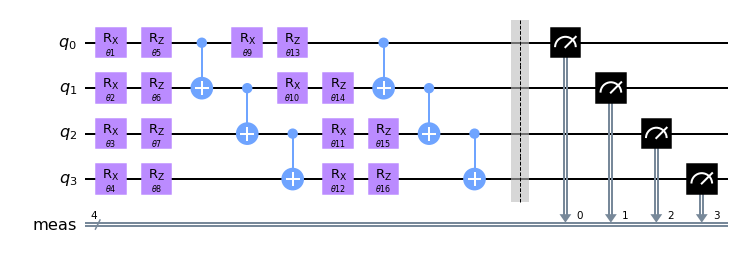

In [7]:
number_of_qubits = 4
number_of_layers = 2

circuit = get_circuit(number_of_qubits, number_of_layers)
circuit.draw("mpl")

You can see that there are $16$ $\theta$ parameters $\theta_1, \dots \theta_{16}$ in the circuit. In fact, the circuit has $2\cdot n \cdot d$ parameters in general. Let us select random parameters $\theta_i \in [0, 2\pi]$ and observe the measurement outcome distribution.

The results was: {'1111': 283, '1011': 218, '1010': 23, '0001': 72, '0100': 63, '1100': 13, '0011': 77, '0101': 99, '0111': 14, '1110': 24, '0000': 67, '1001': 23, '0010': 6, '0110': 8, '1000': 4, '1101': 6}


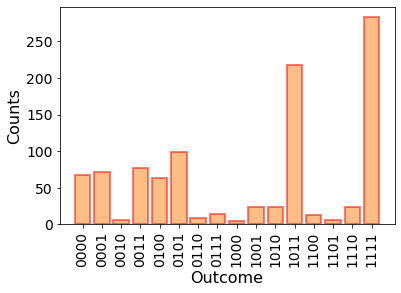

In [8]:
np.random.seed(42)

# the quantum circuit has 2*n*d parameters
number_of_parameters = 2 * number_of_qubits * number_of_layers

# define value for the initial parameters
parameters = np.random.uniform(0, 2 * np.pi, size=number_of_parameters)

# bind the circuit parameters to numbers
circuit_with_params = circuit.bind_parameters(parameters)

# run the circuit and get the result
result = simulator.run(circuit_with_params, shots=1000).result()

# extract the measurement counts as a python dictionary
model_dict = result.get_counts()

print("The results was:", model_dict)

# for convenience sort by binary order 
model_dict = dict(sorted(model_dict.items()))

# do the plotting
fig, ax = plt.subplots(1, 1)

plt.bar(
    model_dict.keys(),
    model_dict.values(),
    alpha=0.5,
    color="tab:orange",
    edgecolor="red",
    linewidth=2,
)

plt.xticks(rotation="vertical")
ax.set_ylabel("Counts", fontsize=16)
ax.set_xlabel("Outcome", fontsize=16)
ax.tick_params(labelsize=14)
plt.show()

Lets think about what this plot represents. We start out with four qubits and a quantum circuit acting on it. Then we prepare and measure the quantum state multiple times and observe outcomes of the encoded proabbility distirbution. Does this sound familiar to you? You might think this sounds like a generative model - and you are right! The parametrized quantum state encodes our model distribution, and we can generate data from it by measuring the qubits. 

The **data** now is discrete, i.e., it consists of "0"s and "1"s, instead of continuous numbers in the domain $[-1.5, 1.5]$ as in our earlier tutorials. You can think of quantum circuit generative models as enabling continuous parametrization of a discrete probability distribution with $2^n$ possible outcomes - something, that is not easily done classically. While it may seem that only being able to model discrete probability distributions is a limitation, but in fact there are many potential use cases for generative models on discrete data, e.g., in finance applications.

## A dataset for quantum computers

So lets think about a potential dataset for our quantum generative model. Last time, the data looked like this:

In [9]:
data_samples = np.array(
    [
        -3.61078109e-01,
        -1.29291442e-01,
        -9.82588388e-02,
        -2.58432923e-01,
        -4.97863965e-01,
        -4.78795061e-01,
        -5.10663163e-01,
        4.36223299e-02,
        -1.01858250e-02,
        -5.57657880e-01,
        -5.61011437e-01,
        -2.63656495e-01,
        -5.00136079e-01,
        -6.30125377e-01,
        -1.12999295e-01,
        -3.22838879e-01,
        -7.75881873e-01,
        1.68190537e-01,
        -2.69496934e-01,
        -3.04754810e-01,
        -2.62099948e-01,
        1.36922064e-01,
        3.93391710e-01,
        -8.12181958e-01,
        -3.15903057e-01,
        1.10533721e-01,
        -2.50864695e-01,
        6.56386891e-02,
        -2.37497275e-01,
        -6.04398679e-01,
        -5.32560555e-01,
        -1.62669444e-01,
        -4.45701188e-01,
        -1.67952827e-01,
        -5.07722157e-01,
        -8.51854037e-02,
        -1.35821066e00,
        -3.39440908e-01,
        -6.41656480e-01,
        -9.51452941e-01,
        -8.23083293e-01,
        -5.69844420e-01,
        -1.04400576e-01,
        -3.71350420e-01,
        -8.65458568e-01,
        -2.64222047e-01,
        8.06578890e-04,
        -5.68337779e-01,
        -6.25077227e-01,
        -1.00012510e00,
        7.59518951e-01,
        2.46827712e-01,
        5.70561107e-01,
        6.52003162e-01,
        6.73384341e-01,
        8.04894781e-01,
        6.34541410e-01,
        3.63315273e-01,
        4.36242632e-01,
        3.31473086e-01,
        5.18170902e-01,
        6.00943305e-01,
        7.09919182e-01,
        5.42156544e-01,
        5.96010036e-01,
        6.32350524e-01,
        5.11792431e-01,
        7.26352234e-01,
        5.24889933e-01,
        6.33500447e-01,
        7.76251971e-01,
        7.53647980e-01,
        3.36153030e-01,
        8.15441364e-01,
        5.57272462e-01,
        1.44661947e-01,
        6.16792976e-01,
        6.91086153e-01,
        6.87286823e-01,
        3.98429153e-01,
        1.07054311e00,
        6.24690432e-01,
        6.84406406e-01,
        7.26905590e-01,
        3.09651946e-01,
        7.78085930e-01,
        3.60425786e-01,
        6.33481589e-01,
        3.17310855e-01,
        6.56363955e-01,
        6.10979533e-01,
        8.08938177e-01,
        7.71336408e-01,
        6.11452930e-01,
        5.03192825e-01,
        5.66868324e-01,
        7.22434360e-01,
        5.64687162e-01,
        5.11510302e-01,
        7.02255988e-01,
    ]
)

Plot it up:

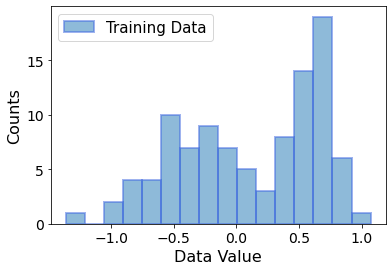

In [10]:
fig, ax = plt.subplots(1, 1)

x_points = np.linspace(-1.5, 1.5, 1000)

plt.hist(
    data_samples,
    bins=16,
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=2,
    label="Training Data",
)

plt.legend(fontsize=15)
ax.set_ylabel("Counts", fontsize=16)
ax.set_xlabel("Data Value", fontsize=16)
ax.tick_params(labelsize=14)
plt.show()

We already suggestively plotted a histogram of the continuous data with $16$ bins. What we are going to do now is to count the number of data samples in each bin, and assign each bin to one of the $16$ possible binary outcomes of a quantum circuit. It is most comforable to assign them in the order of ascending binary numbers, i.e., $0000, 0001, 0010, \dots, 1110, 1111$.

In [11]:
# get the data in 16 bins and extract the counts
counts, bins = np.histogram(data_samples, bins=16)

# generate the 2^4 = 16 discrete outcomes as bitstrings 
string_outcomes = [
    bin(ii)[2:].zfill(number_of_qubits) for ii in range(2**number_of_qubits)
]

# group counts and strings into a dictionary
training_data_dict = dict(zip(string_outcomes, counts))

print(training_data_dict)

{'0000': 1, '0001': 0, '0010': 2, '0011': 4, '0100': 4, '0101': 10, '0110': 7, '0111': 9, '1000': 7, '1001': 5, '1010': 3, '1011': 8, '1100': 14, '1101': 19, '1110': 6, '1111': 1}


This new form of the data looks very familiar to *qiskit* practitioners. It represents a discretized form of the continuous dataset, and can in fact be plotted together with our quantum circuit outcomes:

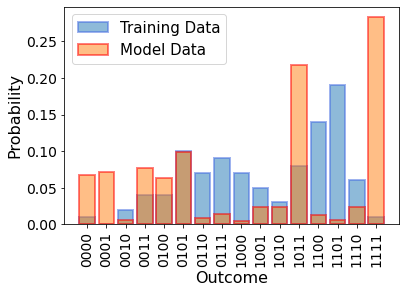

In [12]:
fig, ax = plt.subplots(1, 1)

x_points = np.linspace(-1.5, 1.5, 1000)

plt.bar(
    training_data_dict.keys(),
    np.array(list(training_data_dict.values())) / sum(training_data_dict.values()), # turn the counts into probabilities
    alpha=0.5,
    edgecolor="royalblue",
    linewidth=2,
    label="Training Data",
)
plt.bar(
    model_dict.keys(),
    np.array(list(model_dict.values())) / sum(model_dict.values()), # turn the counts into probabilities
    alpha=0.5,
    edgecolor="red",
    linewidth=2,
    label="Model Data",
)

plt.xticks(rotation="vertical")
plt.legend(fontsize=15)
ax.set_ylabel("Probability", fontsize=16)
ax.set_xlabel("Outcome", fontsize=16)
ax.tick_params(labelsize=14)
plt.show()

While we are able to plot the training data probabilities and our empirical quantum circuit measurement probabilities together, the distributions clearly don't match at all. In the previous tutorials, we could make educated guesses for how to parametrize the gaussian model to match the gaussian data, but would you know how to do that with a parametrized quantum circuit? No, that is too hard to know in general and for arbitrary datasets. This is where training of the model parameters comes in. For that we need a loss function.

## A loss function for generative modeling

We remember the KL divergence from the last tutorial:

$$\text{KL}(p_{data}, p_{model}) = \sum_{x\sim \mathcal{D}} \left[ p_{data}(x) \log(p_{data}(x)) - p_{data}(x) \log(p_{model}(x)) \right]$$

Since we are now working with discrete $x$ as well as dictionaries of measurement counts, we will have to define a KL divergence loss function that accepts these formats:

In [13]:
def kl_divergence(data_distribution, model_distribution):
    # we will require a small offset "e" to avoid possible log(0) singularities
    e = 1e-6

    # make sure the values in the dictionaries add up to 1
    sum_data = sum(data_distribution.values())
    sum_model = sum(model_distribution.values())
    for bin_outcome, count in data_distribution.items():
        data_distribution[bin_outcome] = max(count / sum_data, e)
    for bin_outcome, count in model_distribution.items():
        model_distribution[bin_outcome] = max(count / sum_model, e)

    # calculate the first term in the KL divergence formula
    term1 = 0
    for bin_outcome, prob in data_distribution.items():
        term1 += prob * np.log(prob)

    # calculate the second term in the KL divergence formula
    term2 = 0
    for bin_outcome, prob in data_distribution.items():
        term2 += prob * np.log(model_distribution.get(bin_outcome, e))

    return term1 - term2

And measure our *initial* loss given the dataset, our quantum circuit, and a random parameter guess.

In [14]:
kl_divergence(training_data_dict, model_dict)

1.4587267014826186

## Wrapping it up

As expected, the KL divergence is not zero and in fact quite large. In the next tutorial in this series on generative modeling using quantum hardware, we will apply the gradient descent optimization algorithm to train the circuit parameters to match this particular data distribution. Furthermore, we will study the role that *entanglement* plays in this algorithm and how it affects training performance.

To summarize what we saw in this tutorial, we went implemented a quantum circuit generative **model** using *qiskit*. Because of the binary nature of qubit measurements, quantum circuit generative models operate on datasets consisting of discrete **data**. Interestingly, we were able to transfer the continuous dataset from the earlier tutorials and transform it into a dataset that's suitable for quantum circuits. However, the initial KL divergence value between the training dataset and $1000$ samples from our quantum circuit model was still quite large.

See you soon when we train this quantum circuit model!